# Transform a destination pixel into a location in the source image with an int16 displacement field
We align a source image by transforming it into a destination image. The transform is defined by a displacement field. This displacement field is defined in the space of the destination image, such that each pixel in the displacement field is a vector that indicates the relative displacement of the source image that should be written to this pixel in the destination. In some instances, we define our displacement fields in an int16 format to reduce storage size. This notebook will demonstrate how to transform a destination pixel to a location in the source using a displacement field stored as an int16.

### Define data locations  
Here's a [neuroglancer link](https://macastro-int16-dot-neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22transform%22%2C%22transform%22:%5B%5B1.0750000476837158%2C0%2C0%2C0%5D%2C%5B0%2C1.0750000476837158%2C0%2C0%5D%2C%5B0%2C0%2C1.125%2C0%5D%2C%5B0%2C0%2C0%2C1%5D%5D%2C%22source%22:%22precomputed://gs://vnc1_r066/alignmentV3/cloudvolume%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22src_img%22%7D%2C%7B%22tab%22:%22transform%22%2C%22source%22:%22precomputed://gs://zetta_lee_fly_vnc_001_precomputed/vnc1_full_v3align_2/realigned_v1%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22dst_img%22%7D%2C%7B%22tab%22:%22transform%22%2C%22source%22:%22precomputed://gs://zetta_lee_fly_vnc_001_alignment_temp/vnc1_full_v3align_2/0-90000_0-230000_10-4400/v2/field/stitchdecay25/compose%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shader%22:%22#define%20SCALE%20200.0%5Cn#define%20RED%20vec3%281.%2C0.%2C0.%29%5Cn#define%20CYAN%20vec3%280.%2C1.%2C1.%29%5Cn#define%20GREEN%20vec3%28.5%2C1.%2C0.%29%5Cn#define%20BLUE%20vec3%28.5%2C0.%2C1.%29%5Cn%5Cnvoid%20main%20%28%29%20%7B%5Cn%20%20float%20x%20=%20toNormalized%28getDataValue%280%29%29%3B%5Cn%20%20float%20y%20=%20toNormalized%28getDataValue%281%29%29%3B%5Cn%20%20if%20%28x%20%3E%200.5%29%20%7B%5Cn%20%20%20%20x%20=%20x%20-%201.0%3B%5Cn%20%20%7D%5Cn%20%20if%20%28y%20%3E%200.5%29%20%7B%5Cn%20%20%20%20y%20=%20y%20-%201.0%3B%5Cn%20%20%7D%5Cn%20%20vec3%20x_color%20=%20%28-x%29%2AGREEN%20+%20x%2ABLUE%3B%5Cn%20%20vec3%20y_color%20=%20%28-y%29%2ACYAN%20+%20y%2ARED%3B%5Cn%20%20emitRGB%28%28x_color%20+%20y_color%29%2ASCALE%29%3B%5Cn%7D%5Cn%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22field%22%7D%5D%2C%22navigation%22:%7B%22pose%22:%7B%22position%22:%7B%22voxelSize%22:%5B4.300000190734863%2C4.300000190734863%2C45%5D%2C%22voxelCoordinates%22:%5B44999.3046875%2C172327.28125%2C1880%5D%7D%7D%2C%22zoomFactor%22:31.06879034079089%7D%2C%22layout%22:%22xy%22%7D) for the data involved in this example. (Note that the neuroglancer branch is not the master branch that we typically use. This is so we can visualize int16 precomputed data.)    

We've also applied a color scheme to the `field` layer to correspond to this colorwheel (vectors with a norm >= ~57 px map to the edge of this wheel):  <img src="https://i.stack.imgur.com/ZzAii.png" alt="vector:colorwheel" width="40"/>  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cloudvolume import CloudVolume
from cloudvolume.lib import Bbox, Vec

The paths for these CloudVolumes have been adjusted to be readable without a service key. For more information on reading from public datasets, see the [cloudvolume wiki](https://github.com/seung-lab/cloud-volume/wiki/Reading-Public-Data-Examples).

In [2]:
src_mip = np.array([4,4,40])
dst_mip = np.array([4.3,4.3,45]) # resolution was adjusted in the alignment process
field_mip = np.array([17.2,17.2,45])
src_img = CloudVolume('https://storage.googleapis.com/vnc1_r066/alignmentV3/cloudvolume', mip=src_mip, progress=False)
dst_img = CloudVolume('https://storage.googleapis.com/lee-lab_female-adult-nerve-cord/alignmentV4/em/slicewise', mip=dst_mip, progress=False)
field   = CloudVolume('https://storage.googleapis.com/zetta_lee_fly_vnc_001_alignment_temp/vnc1_full_v3align_2/0-90000_0-230000_10-4400/v2/field/stitchdecay25/compose', mip=field_mip, progress=False)
field.mip

2

### Define methods for downloading & formatting vector  
Each of our CloudVolumes stores data at a different resolution. We create a helper method to allow us to work in the pixel space of the full-resolution (MIP0).

In [10]:
def get_point(vol, pt):
    """Download MIP0 point from a CloudVolume
    
    Args:
        vol (CloudVolume): CloudVolume at any MIP
        pt (np.array): 3-element point defined at MIP0
        
    Returns:
        CloudVolume element at location
    """
    mip = vol.mip
    res = np.array([2**mip, 2**mip, 1])
    return vol[list(pt // res)] 


Our vectors are permuted and stored as int16 for processing convenience. For this use case, we should convert them into the same format as our pixel locations.

In [11]:
def to_vec(v):
    """Format CloudVolume element as vector
    
    Args:
        v (np.array): 4D element as np.int16
        
    Returns:
        np.array, 3D vector as np.float
    """
    return np.array([np.float32(v[0,0,0,1]) / 4, np.float32(v[0,0,0,0]) / 4, 0])

def get_vec(vol, pt):
    """Download vector at location defined at MIP0 from CloudVolume at any MIP
    
    Args:
        vol (CloudVolume): CloudVolume of field as int16
        pt (np.array): 3-element point
        
    Returns:
        np.array, 3D vector at MIP0
    """
    return to_vec(get_point(vol, pt))   

### Define & transform a pixel from the destination 

Define the destination point at full-resolution (4.3 x 4.3 x 45 nm$^3$).

In [12]:
dst_pt = np.array([47646, 173835, 1880])

Download the vector at this destination pixel, indicating the relative displacement to a location in the source.

In [13]:
v = get_vec(field, dst_pt)
v

array([128.75,  24.25,   0.  ])

Add the vector to the destination pixel to retrieve the source locaiton.

In [19]:
src_pt = dst_pt + v
src_pt

array([ 47774.75, 173859.25,   1880.  ])

### Verify correspondence  
We'll download a small cutout around both points in the source and destination to verify that we've retrieved the same location.

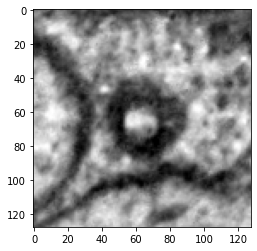

In [15]:
dimg = dst_img.download_point(dst_pt, size=[128,128,1], mip=dst_mip)
plt.imshow(dimg[:,:,0,0], cmap='gray');

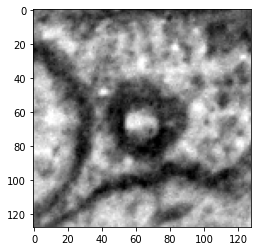

In [16]:
simg = src_img.download_point(src_pt, size=[128,128,1], mip=src_mip)
plt.imshow(simg[:,:,0,0], cmap='gray');

Here's a [neuroglancer link](https://macastro-int16-dot-neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22tab%22:%22transform%22%2C%22transform%22:%5B%5B1.0750000476837158%2C0%2C0%2C0%5D%2C%5B0%2C1.0750000476837158%2C0%2C0%5D%2C%5B0%2C0%2C1.125%2C0%5D%2C%5B0%2C0%2C0%2C1%5D%5D%2C%22source%22:%22precomputed://gs://vnc1_r066/alignmentV3/cloudvolume%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22src_img%22%7D%2C%7B%22tab%22:%22transform%22%2C%22source%22:%22precomputed://gs://zetta_lee_fly_vnc_001_precomputed/vnc1_full_v3align_2/realigned_v1%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22dst_img%22%2C%22visible%22:false%7D%2C%7B%22tab%22:%22transform%22%2C%22source%22:%22precomputed://gs://zetta_lee_fly_vnc_001_alignment_temp/vnc1_full_v3align_2/0-90000_0-230000_10-4400/v2/field/stitchdecay25/compose%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shader%22:%22#define%20SCALE%20200.0%5Cn#define%20RED%20vec3%281.%2C0.%2C0.%29%5Cn#define%20CYAN%20vec3%280.%2C1.%2C1.%29%5Cn#define%20GREEN%20vec3%28.5%2C1.%2C0.%29%5Cn#define%20BLUE%20vec3%28.5%2C0.%2C1.%29%5Cn%5Cnvoid%20main%20%28%29%20%7B%5Cn%20%20float%20x%20=%20toNormalized%28getDataValue%280%29%29%3B%5Cn%20%20float%20y%20=%20toNormalized%28getDataValue%281%29%29%3B%5Cn%20%20if%20%28x%20%3E%200.5%29%20%7B%5Cn%20%20%20%20x%20=%20x%20-%201.0%3B%5Cn%20%20%7D%5Cn%20%20if%20%28y%20%3E%200.5%29%20%7B%5Cn%20%20%20%20y%20=%20y%20-%201.0%3B%5Cn%20%20%7D%5Cn%20%20vec3%20x_color%20=%20%28-x%29%2AGREEN%20+%20x%2ABLUE%3B%5Cn%20%20vec3%20y_color%20=%20%28-y%29%2ACYAN%20+%20y%2ARED%3B%5Cn%20%20emitRGB%28%28x_color%20+%20y_color%29%2ASCALE%29%3B%5Cn%7D%5Cn%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22field%22%7D%5D%2C%22navigation%22:%7B%22pose%22:%7B%22position%22:%7B%22voxelSize%22:%5B4.300000190734863%2C4.300000190734863%2C45%5D%2C%22voxelCoordinates%22:%5B47774%2C173859%2C1880%5D%7D%7D%2C%22zoomFactor%22:4.600678484717683%7D%2C%22layout%22:%22xy%22%7D) to this location.